In [1]:
import os
import numpy as np
import pandas as pd

from itertools import product
from collections import defaultdict

import itertools

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

import mpl_toolkits.axisartist as axisartist
# import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import PowerNorm

from matplotlib.colors import ListedColormap

# %matplotlib widget
%matplotlib inline

os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'False'
matplotlib.rcParams['font.family'] = 'monospace'

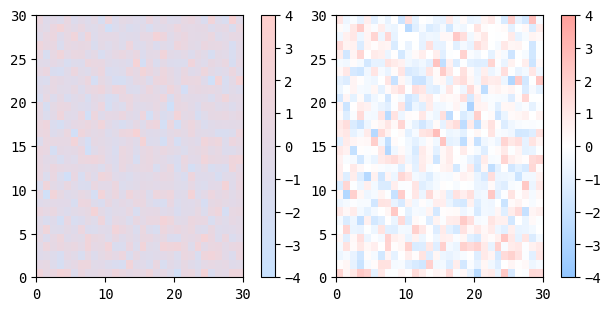

In [2]:
colors = list()
# with plt.style.context("default"):
with plt.style.context("seaborn-v0_8-pastel"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        colors.append(color['color'])
i, j = 1, 0
i, j = 2, 0
d = 256

v = np.ones((d, 4))
for ch in range(3):
    v[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)/2 \
               + np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)/2
seq_cmap = ListedColormap(v)

d = 128
v_up = np.ones((d, 4))
v_bot = np.ones((d, 4))
for ch in range(3):
    v_up[:, ch] = np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)
    v_bot[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)
div_cmap = ListedColormap(np.vstack((v_up, v_bot)))


def plot_examples(colormaps):
    np.random.seed(0)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()


plot_examples([seq_cmap, div_cmap])

In [3]:
class FirstElementHashable(tuple):
    def __eq__(self, comp):
        return self[0] == comp[0]

    def __ne__(self, comp):
        return self[0] != comp[0]

    def __hash__(self):
        return hash((self[0],))

class HashableDict(dict):
    def __eq__(self, comp):
        return self['id'] == comp['id']

    def __ne__(self, comp):
        return self['id'] != comp['id']

    def __hash__(self):
        return hash(self['id'])

def params_dict_to_string(d):
    st = list()
    for k, v in d.items():
        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        else:
            if k[-1] == "_":
                k = k[:-1]
            v = str(v)#.replace('{', '(').replace('}', ')')
            st.append(f"{k}={v}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st


def title_from_dict(d):
    st = list()
    for k, v in d.items():
        # if k not in ya_keys:
        #     continue

        # if k[-1] == '_':
        #     k = k[:-1]

        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        elif isinstance(v, set):
            # print(v)
            for i in v:
                if i is not None:
                    break
            # v = str(i).replace('{', '(').replace('}', ')')
            st.append(f"{k}={i}")
        else:
            st.append(f"{k}={str(v)}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st

In [4]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())
# experiment_name = 'GPU'

In [5]:
markers = ['^', '<', '>', 'v', 'o', 's', 'D', '*']

In [6]:
# query = 'params.model="Net" and params.seed="1" and params.md_lr_!="0.1"'
query = 'params.model="Net" and params.seed="3"'
# query = 'params.model="VGG11"'
query = 'params.model="ResNet18"'
# query = 'params.model="MNISTNet" and params.batch_size="200"'
# query = 'params.model="Net" and params.batch_size="180"'


label_keys = ['optimizer', 'mdfull_', 'trueweights']
same_plot = ['seed', 'niters']
ya_keys = ['hratio']

client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string=query,
                          run_view_type=ViewType.ACTIVE_ONLY)
configs = list()
ya_keys_set = set()  # contains parameters which can be None for some runs
id_lookup_set = set()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json', )
    configs.append(config)

    for k in config:
        v = config[k]
        if isinstance(v, dict):
            v = HashableDict(v)
            config[k] = v
            configs[-1][k] = v

        if k[-1] == '_' and k not in label_keys and k not in same_plot:
            ya_keys_set.add(k)

        d = dict()
        for k in label_keys: #  or k in same_plot:
            d.update({k: v})
        id_lookup_set.add(str(d))

id_lookup_list = list(id_lookup_set)
ya_keys += list(ya_keys_set)
ya_keys
params_set = set()
sparse_configs = list()

for i, r in enumerate(runs):
    config = configs[i]

    sparse_cfg = dict()
    for k, v in config.items():
        if k in label_keys or k in ya_keys or k in same_plot:
            continue
        sparse_cfg.update({k: v})
    params_set.add(str(sparse_cfg))
    sparse_configs.append(sparse_cfg)
    
params_set

{"{'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'ResNet18', 'id': 3}, 'dataset': {'name': 'CIFAR10', 'id': 2}, 'nsamples': 1000, 'batchsize': 200, 'lr': 0.01}"}

In [7]:
params_list = list(params_set)
ya_dicts_list = [set() for _ in params_set]
for i, r in enumerate(runs):
    config = configs[i]
    sparse_config = sparse_configs[i]
    i = params_list.index(str(sparse_config))

    d = dict()
    for k in ya_keys:
        if k not in same_plot:# and k not in label_keys:
            d.update({k: config[k]})
    ya_dicts_list[i].add(str(d))

In [8]:
ya_dicts_list

[{"{'hratio': 0.5, 'mdniters_': None, 'mdlr_': None}",
  "{'hratio': 0.7, 'mdniters_': None, 'mdlr_': None}",
  "{'hratio': 0.99, 'mdniters_': 20, 'mdlr_': 0.05}",
  "{'hratio': 0.99, 'mdniters_': 20, 'mdlr_': 0.1}",
  "{'hratio': 0.99, 'mdniters_': None, 'mdlr_': None}",
  "{'hratio': None, 'mdniters_': None, 'mdlr_': None}"}]

In [9]:
ya_dicts_list[0]

{"{'hratio': 0.5, 'mdniters_': None, 'mdlr_': None}",
 "{'hratio': 0.7, 'mdniters_': None, 'mdlr_': None}",
 "{'hratio': 0.99, 'mdniters_': 20, 'mdlr_': 0.05}",
 "{'hratio': 0.99, 'mdniters_': 20, 'mdlr_': 0.1}",
 "{'hratio': 0.99, 'mdniters_': None, 'mdlr_': None}",
 "{'hratio': None, 'mdniters_': None, 'mdlr_': None}"}

In [10]:
# dicts = ya_dicts_list[0]

# d_out = defaultdict(set)
# for d in dicts:
#     for k, v in _eval(d).items():
#         if v is not None:
#             d_out[k].add(v)
    

In [11]:


# for i in product_dict(**d_out):
#     print(f"{i=}")

In [12]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

def _eval(d):
    d = eval(d)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
    return d

In [13]:
params_lists = list()
for p in params_set:
    d = _eval(p)
    params_lists.append([d.copy()])

runs_sets_lists = [[set()] for _ in params_lists]
for j, params_list in enumerate(params_lists):
    ya_dicts = [_eval(d) for d in sorted(ya_dicts_list[j])]
    
    ya_sparse = defaultdict(set)
    for d in ya_dicts:
        for k, v in d.items():
            if v is not None:
                ya_sparse[k].add(v)

        
    for d in product_dict(**ya_sparse):
        # if None in set(d.values()):
        #     continue
        d.update(params_list[0])
        params_list.append(d.copy())
        runs_sets_lists[j].append(set())
        print(f"{runs_sets_lists[j]=}")

print(f"{len(runs_sets_lists)=}")

runs_sets_lists[j]=[set(), set()]
runs_sets_lists[j]=[set(), set(), set()]
runs_sets_lists[j]=[set(), set(), set(), set()]
runs_sets_lists[j]=[set(), set(), set(), set(), set()]
runs_sets_lists[j]=[set(), set(), set(), set(), set(), set()]
runs_sets_lists[j]=[set(), set(), set(), set(), set(), set(), set()]
len(runs_sets_lists)=1


In [14]:
def params_in_config(params, config, sparse=False):
    for k in params:
        if k not in ya_keys and config[k] != params[k]:
            return False

    for k in ya_keys:
        if config[k] is not None and ((k in params and config[k] != params[k]) or sparse):
            return False
    return True

sparse_extended = [False for _ in params_lists]
for i, r in enumerate(runs):
    config = configs[i]

    for j, params_list in enumerate(params_lists):
        for t, params in enumerate(params_list):
            if params_in_config(params_list[t], config, not t):
                runs_sets_lists[j][t].add(FirstElementHashable((r, config)))
                if t:
                    sparse_extended[j] = True

In [15]:
sparse_extended

[True]

In [16]:
labels = set()
for r in runs:
    labels.add(r.info.run_name)

lookup_id_dict = {v: i for i, v in enumerate(labels)}

def iterate_run_sets():
    for j, params_list in enumerate(params_lists):
        if sparse_extended[j] is False:
            yield params_list[0], runs_sets_lists[j][0]
        else:
            for i, params in enumerate(params_list):
                if i and len(runs_sets_lists[j][i]):
                    yield params, runs_sets_lists[j][i].copy().union(runs_sets_lists[j][0].copy())

params={'hratio': 0.5, 'mdniters_': 20, 'mdlr_': 0.05, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'ResNet18', 'id': 3}, 'dataset': {'name': 'CIFAR10', 'id': 2}, 'nsamples': 1000, 'batchsize': 200, 'lr': 0.01}

params={'hratio': 0.5, 'mdniters_': 20, 'mdlr_': 0.1, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'ResNet18', 'id': 3}, 'dataset': {'name': 'CIFAR10', 'id': 2}, 'nsamples': 1000, 'batchsize': 200, 'lr': 0.01}

params={'hratio': 0.7, 'mdniters_': 20, 'mdlr_': 0.05, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'ResNet18', 'id': 3}, 'dataset': {'name': 'CIFAR10', 'id': 2}, 'nsamples': 1000, 'batchsize': 200, 'lr': 0.01}

params={'hratio': 0.7, 'mdniters_': 20, 'mdlr_': 0.1, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'ResNet18', 'id': 3}, 'dataset': {'name': 'CIFAR10', 'id': 2}, 'nsamples': 1000, 'batchsize': 200, 'lr': 0.01}

params={'hratio': 

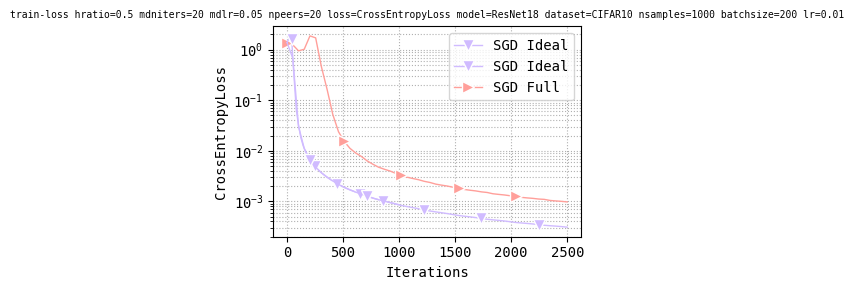

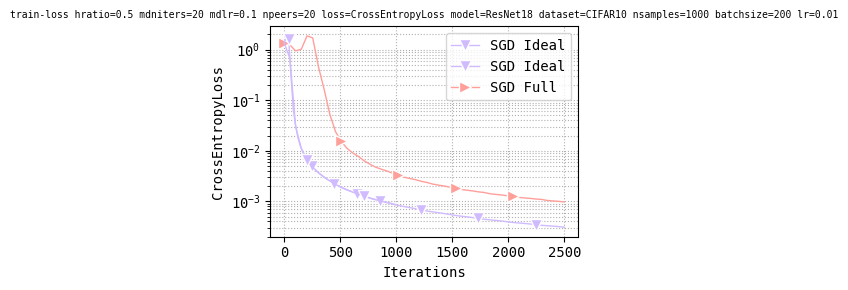

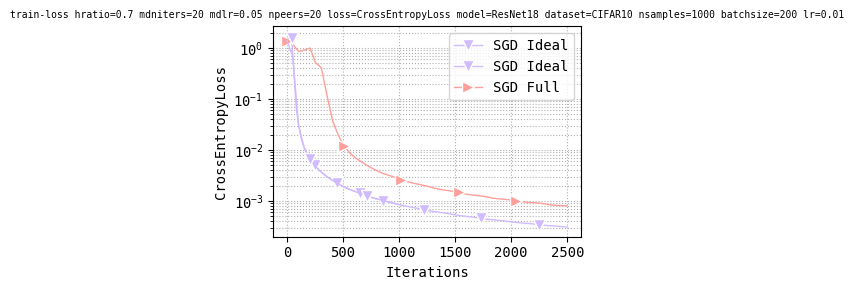

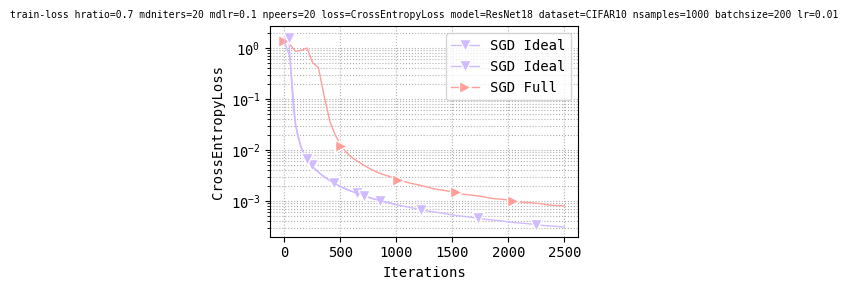

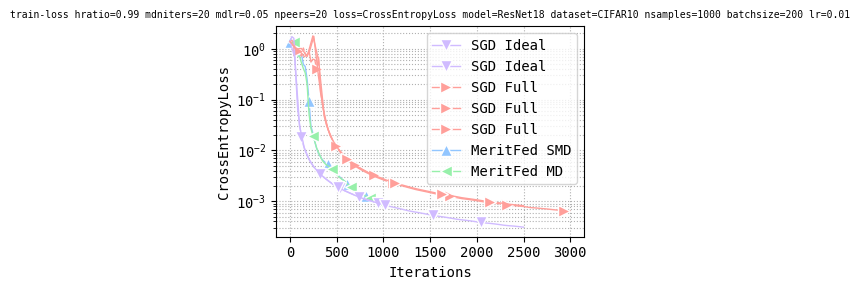

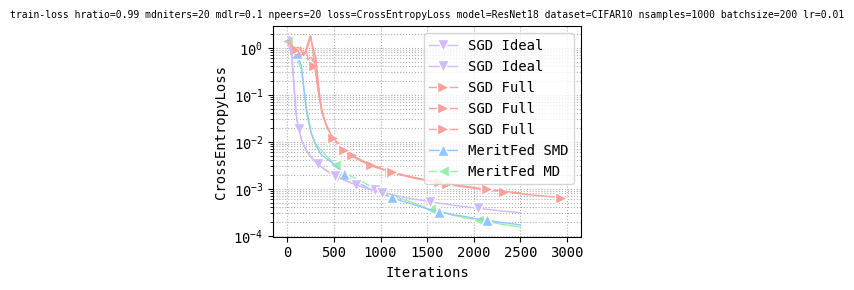

In [17]:
beg = 0
end = 20000
metric_key = 'train-loss'
# metric_key = 'test-loss'
# metric_key = 'expected-loss'
for i, (params, runs) in enumerate(iterate_run_sets()):
    print(f"{params=}")
    print()
    if  not len(runs):
        continue

    title = params_dict_to_string(params)
    fig, ax = plt.subplots(figsize=(4, 3))
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        id = lookup_id_dict[label]
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 10), markersize=8,
                label=label, linewidth=1,
                markeredgecolor='white', markeredgewidth=1)

    ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.grid(True, which="both", ls='dotted')        
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    ax.legend(handles, labels)
    # ax.legend(loc='center right')


    ax.set_xlabel('Iterations')
    # ax.set_xscale('log')
    ax.set_ylabel(params['loss']['name'])
    ax.set_yscale('log')
    # ax.set_ylabel(r'Accuracy')
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # formatter = mtick.ScalarFormatter()
    # formatter.set_scientific(True)
    # ax.yaxis.set_minor_formatter(formatter)
    # ax.yaxis.set_major_formatter(formatter)
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(.1,.1))

    name = metric_key + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    plt.tight_layout()
    fig.show()

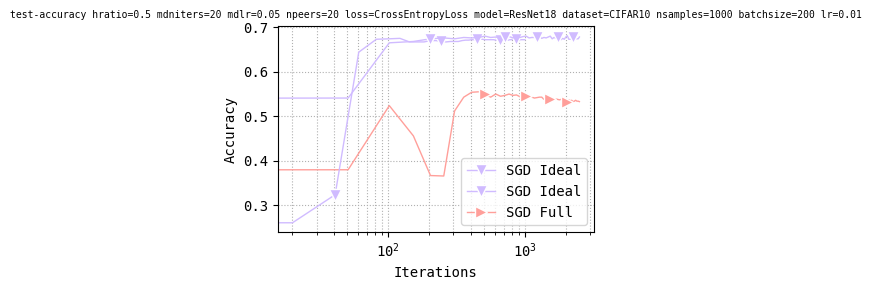

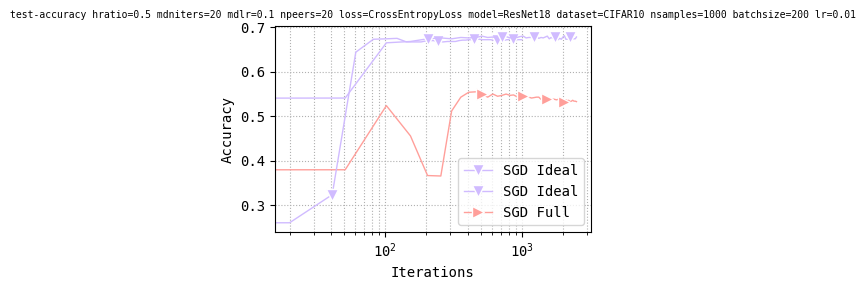

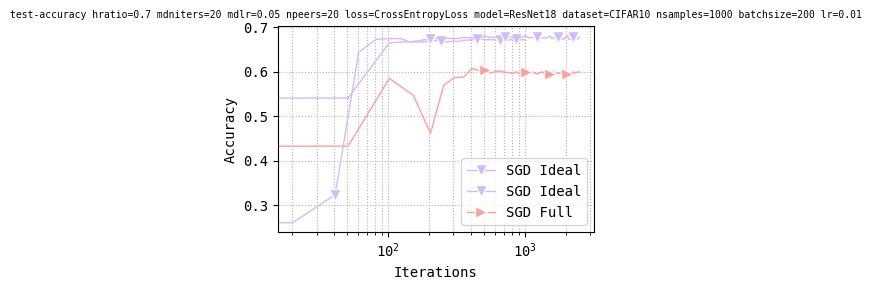

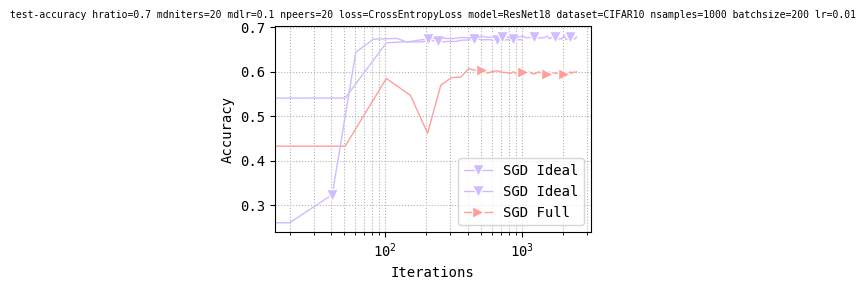

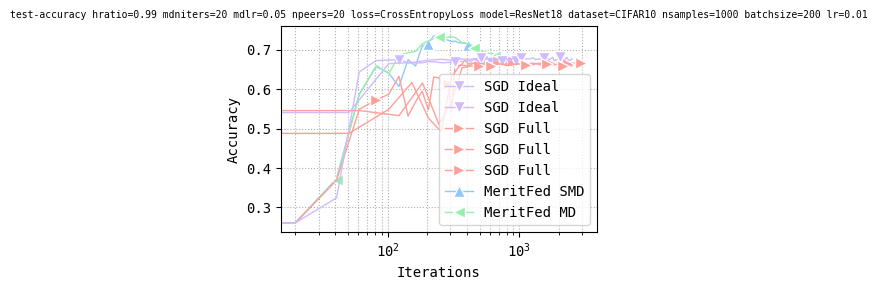

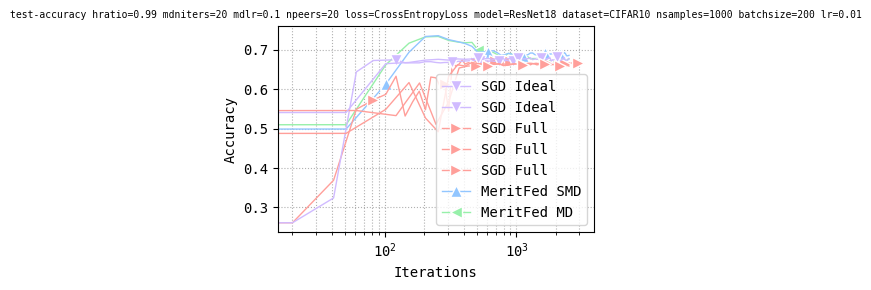

In [18]:
beg = 0
end = 20000
metric_key = 'test-accuracy'
# metric_key = 'train-accuracy'
for i, (params, runs) in enumerate(iterate_run_sets()):
    # print(f"{params=}")
    # print(f"{i=}")
    # print()

    title = params_dict_to_string(params)
    fig, ax = plt.subplots(figsize=(4, 3))
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        id = lookup_id_dict[label]
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 10), markersize=8,
                label=label, linewidth=1,
                markeredgecolor='white', markeredgewidth=1)

    ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.grid(True, which="both", ls='dotted')        
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    ax.legend(handles, labels)
    # ax.legend(loc='center right')

    ax.set_xlabel('Iterations')
    ax.set_xscale('log')

    ax.set_ylabel('Accuracy')
    # ax.set_yscale('log')
    # ax.set_ylabel(r'Accuracy')
    # plt.gca().invert_yaxis()
    # ax.set_ylim(bottom=0.6)#, top=1)#, *, emit=True, auto=False, ymin=None, ymax=None)
    # ax.set_ylim(bottom=None, top=None, *, emit=True, auto=False, ymin=None, ymax=None)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # formatter = mtick.ScalarFormatter()
    # formatter.set_scientific(True)
    # ax.yaxis.set_minor_formatter(formatter)
    # ax.yaxis.set_major_formatter(formatter)
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(1e-2,1e-2))

    name = metric_key + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    plt.tight_layout()
    fig.show()

In [19]:
for _, (params, runs) in enumerate(iterate_run_sets()):
    count = 0
    min_w, max_w = 1., 0.
    count = 0
    weights = []
    for j, (r, config) in enumerate(runs):
        if config['mdniters_'] is not None:
            count += 1
            for rank in range(config['npeers']):
                k = 'weights_%s' % (str(rank))
                history = client.get_metric_history(run_id=r.info.run_id, key=k)
                y = np.array([h.value for h in history])
                weights.append(y.min())
                weights.append(y.max())
    weights = np.array(weights)

    min_w = min(min_w, weights.min())
    max_w = max(max_w, weights.max())
    
    if count == 0:
        continue

    fig = plt.figure(figsize=(4, 2))
    gs = GridSpec(nrows=1, ncols=count)
    axs = list()
    for j in range(count):
        axs.append(fig.add_subplot(gs[0, j], axes_class=axisartist.Axes))

    im = None
    for j, (r, config) in enumerate(runs):
        if config['mdniters_'] is None:
            continue
        
        weights = []
        labels = list()
        y_ticks_map = np.linspace(0, config['n_peers']-1, 10, endpoint=True).round().astype(int)
        for rank in range(config['n_peers']):
            k = 'weights_%s' % (str(rank))
            if rank in y_ticks_map:
                labels.append(r'$  w_{%s}$' % (str(rank+1)))
            else:
                labels.append('')

            history = client.get_metric_history(run_id=r.info.run_id, key=k)
            y = np.array([h.value for h in history])
            x = np.array([h.step for h in history])
            ticks_map = np.linspace(0, len(y)-1, config['npeers'], endpoint=True).round().astype(int)
            y = [y[j] for j in ticks_map]
            weights.append(y)
        weights = np.array(weights)  # .copy()
        
        id = 0 if r.info.run_name == 'MeritFed MD' else 1
        axs[id].set_title(r.info.run_name)

        im = axs[id].matshow(weights, cmap=div_cmap, norm=PowerNorm(gamma=1. / 2.3))
        axs[id].set_xlabel('Iterations')
        axs[id].set_xticks([0, len(ticks_map)-1])
        axs[id].set_xticklabels(['0', str(x[-1])])

        axs[id].axis["left"].major_ticklabels.set_ha("left")
        axs[id].set_yticks(np.arange(len(labels)), labels=labels)

    cbar_ax = fig.add_axes([0., 0.05, .02, 0.85])
    cb = fig.colorbar(im, cax=cbar_ax, location='left', format=mtick.FormatStrFormatter('%.3f'))
    fig.subplots_adjust(wspace=.4)

    name = 'w' + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    fig.show()

ValueError: zero-size array to reduction operation minimum which has no identity